In [17]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

#Importing necessary modules:
import os
import sys
sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")

import time
import copy
import numpy as np
import pylab as plt


#import SRW core functions
from wpg.srwlib import srwl,SRWLOptD,SRWLOptA,SRWLOptC,SRWLOptT,SRWLOptL, SRWLWfr

#import SRW helpers functions
from wpg.useful_code.srwutils import AuxTransmAddSurfHeightProfileScaled

#import some helpers functions
from wpg.useful_code.wfrutils import calculate_fwhm_x, plot_wfront, calculate_fwhm_y, print_beamline, get_mesh

#Import base wavefront class
from wpg import Wavefront

#Gaussian beam generator
from wpg.generators import build_gauss_wavefront_xy

plt.ion()

# Plane wave incidence

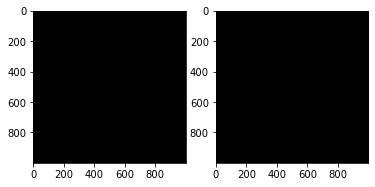

In [231]:
strOutputDataFolder = 'WPG_output'  # output data sub-folder name
# srw plane wavefront constructor
nx = 1000; ny = 1000
E = 9000.0
z = 100
range_xy = 2e-3

wfr = SRWLWfr()
wfr.allocate(1,nx,ny)
wfr.mesh.eStart = E
wfr.mesh.eFin = E
wfr.avgPhotEn = (wfr.mesh.eStart+wfr.mesh.eFin)/2
wfr.mesh.zStart=z
wfr.mesh.xStart = -range_xy/2
wfr.mesh.xFin = range_xy/2
wfr.mesh.yStart = -range_xy/2
wfr.mesh.yFin = range_xy/2

wfr.presFT = 0

wfr.partBeam.partStatMom1.x = 0
wfr.partBeam.partStatMom1.y = 0
wfr.partBeam.partStatMom1.z = 0
wfr.partBeam.partStatMom1.xp = 0
wfr.partBeam.partStatMom1.yp = 0

wfr.arEx = np.ascontiguousarray((np.ones(2*nx*ny)*10000))

# convert to WPG object
wfr_name = strOutputDataFolder+'/planewave.h5'
mwf = Wavefront(wfr)
mwf.store_hdf5(wfr_name)

# plot wavefront
plt.figure()
plt.subplot(1,2,1)
plt.imshow(mwf.get_intensity(slice_number=0))
plt.subplot(1,2,2)
plt.imshow(mwf.get_phase(slice_number=0, polarization='horizontal'))

plt.show()

# Defining optical beamline

In [268]:
# OE thickness functions
def Spherical_lens(x,y,n,f):
    delta_d = f - np.sqrt(f**2-np.square(x)-np.square(y))
    z = delta_d/(n-1)
    return z

In [271]:
# function to calculate optical path differnece and amplitude transmission
def Calc_OPD_and_AmpTr(srwTr, thicknessProfData, n, d_abs):
    N = len(thicknessProfData[0])
    auxMesh = srwTr.mesh
    nx = auxMesh.nx
    ny = auxMesh.ny
    if thicknessProfData.shape==(nx,ny):
        # amplitude transmission
        Tr = np.exp(-thicknessProfData/d_abs)
        # OPD
        OPD = -thicknessProfData*(n-1)
        for iy in range(ny):
            for ix in range(nx):
                ofst = 2*ix + 2*nx*iy
                srwTr.arTr[ofst]=Tr[ix,iy]
                srwTr.arTr[ofst+1]=OPD[ix,iy]
    else:
        print('OE shape not matched')


Text(0.5, 1.0, 'Amplitude Transmission')

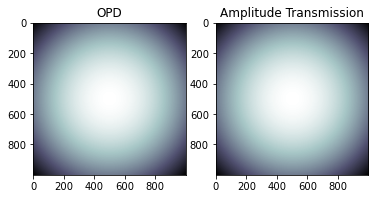

In [291]:
# OE
OE_width = 2e-3    # physical size of OE aperture
n = 1.5            # refractive index
d_abs = 2000e-6    # absorption depth
f = 5

OE_Apt = SRWLOptA('r','a',OE_width,OE_width)
OE_Tr = SRWLOptT(nx,ny,OE_width,OE_width,_Fx=f,_Fy=f,_x=0,_y=0,_eStart=E,_eFin=E)

OE_x = np.linspace(-OE_width/2,OE_width/2,nx)
OE_y = np.linspace(-OE_width/2,OE_width/2,ny)
OE_x, OE_y = np.meshgrid(OE_x,OE_y)

OE_z = Spherical_lens(OE_x,OE_y,n,f)
Calc_OPD_and_AmpTr(OE_Tr, OE_z, n,d_abs)

OPD_show = np.array(OE_Tr.arTr)[1::2].reshape(ny,nx)
AmpTr_show = np.array(OE_Tr.arTr)[0::2].reshape(ny,nx)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(OPD_show)
plt.title('OPD')
plt.subplot(1,2,2)
plt.imshow(AmpTr_show)
plt.title('Amplitude Transmission')

Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.002
	Dy = 0.002
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 5
	Fy = 5
	arTr = array of size 2000000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 9000.0
		eStart = 9000.0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 1000
		ny = 1000
		xFin = 0.001
		xStart = -0.001
		yFin = 0.001
		yStart = -0.001
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 4.0
	treat = 0
	

*****reading wavefront from h5 file...
R-space
nx  1000  range_x [-1.0e+00, 1.0e+00] mm
ny  1000  range_y [-1.0e+00, 1.0e+00] mm
*****propagating wavefront (with resizing)...
save hdf5: WPG_output/detector.h5
done
propagation lasted: 2.928s


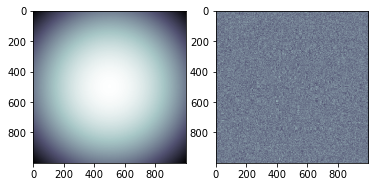

In [292]:
'''WPG syntax'''
# Beamline
from wpg.beamline import Beamline
from wpg.optical_elements import Empty, Use_PP
from wpg.optical_elements import Drift

det_z = z + f*0.8

beamline = Beamline()
beamline.append(OE_Apt, Use_PP())
beamline.append(OE_Tr, Use_PP())
beamline.append(Drift(det_z-z), Use_PP(semi_analytical_treatment=1))

# propagation
from wpg.wpg_uti_wf import propagate_wavefront
from wpg.wpg_uti_oe import show_transmission

wfr_out_name = strOutputDataFolder+'/detector.h5'
startTime = time.time()
mwf = propagate_wavefront(wfr_name, beamline, wfr_out_name)
print('propagation lasted: {}s'.format(round((time.time() - startTime),3)))

# plot wavefront
plt.figure()
plt.subplot(1,2,1)
plt.imshow(mwf.get_intensity(slice_number=0))
plt.subplot(1,2,2)
plt.imshow(mwf.get_phase(slice_number=0, polarization='horizontal'))

plt.show()

propagation lasted: 0.0s


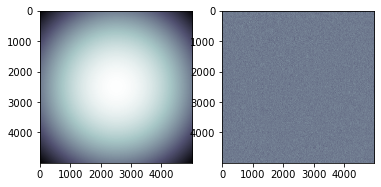

In [293]:
# beamline
Drift_Fin = SRWLOptD(det_z-z)

#Wavefront Propagation Parameters:
#[0]:  Auto-Resize (1) or not (0) Before propagation
#[1]:  Auto-Resize (1) or not (0) After propagation
#[2]:  Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]:  Allow (1) or not (0) for semi-analytical treatment of quadratic phase terms at propagation
#[4]:  Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]:  Horizontal Range modification factor at Resizing (1. means no modification)
#[6]:  Horizontal Resolution modification factor at Resizing
#[7]:  Vertical Range modification factor at Resizing
#[8]:  Vertical Resolution modification factor at Resizing
#[9]:  Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#           [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11] 
pp_Apt =    [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
pp_Tr =     [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDrift =   [ 0,  0, 1.0,  1,  0, 1.0, 5.0, 1.0, 5.0,  0,  0,   0]

beamline = SRWLOptC([OE_Apt, OE_Tr, Drift_Fin], [pp_Apt, pp_Tr, ppDrift])

# propagation
w2 = Wavefront()
w2.load_hdf5(wfr_name)
wfr = w2._srwl_wf
srwl.PropagElecField(wfr, beamline)
startTime = time.time()
mwf = Wavefront(wfr)
print('propagation lasted: {}s'.format(round((time.time() - startTime),3)))

# plot wavefront
plt.figure()
plt.subplot(1,2,1)
plt.imshow(mwf.get_intensity(slice_number=0))
plt.subplot(1,2,2)
plt.imshow(mwf.get_phase(slice_number=0, polarization='horizontal'))

plt.show()